In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! cp drive/MyDrive/Image_Classification/Dataset.zip .
! unzip Dataset.zip -d Dataset/

Archive:  Dataset.zip
replace Dataset/Testing/2015_00401.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! cp drive/MyDrive/Image_Classification/AI_Basic_Test.zip .
! unzip AI_Basic_Test.zip -d CSV_Datset/

Archive:  AI_Basic_Test.zip
replace CSV_Datset/test_set.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import pandas as pd
import torch
from torch import nn as nn
from torchvision import transforms as transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from torchvision import models
from tqdm import tqdm
import math
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
def prepare_dataset(dataset_type):
  list_class_dir = os.listdir(f"Dataset/{str(dataset_type)}")
  dataset = []
  class_dict = {folder :index for index,folder in enumerate(list_class_dir)}
  extension = set()
  for folder in list_class_dir:
    class_path = os.path.join("Dataset/Training" , folder)
    images_path = os.listdir(class_path)
    for image in images_path:
      extension.add(image.split(".")[1])
      dataset.append(dict(
          image_path = os.path.join(class_path,image),
          class_name = class_dict[folder]
      ))
  dataset = pd.DataFrame(dataset,columns=["image_path","class_name"])
  return dataset
training_dataset = prepare_dataset("Training")
validation_dataset = prepare_dataset("Validation")
# this will return the csv file of training and validation dataset, which contains two column(class name, image path)

In [ ]:
# this section is used to prepare the data in batch to train the model
class ImageDataset(Dataset):
  def __init__(self,metadata,transforms = None):
    super(ImageDataset,self).__init__()
    self.metadata = metadata # load the csv file 
    self.length = self.metadata.shape[0] # return the length of data
    self.transforms = transforms # this is tranfroms the image to into tensor
  
  def __len__(self):
    return self.length
  
  def __getitem__(self,index):
    data = self.metadata.iloc[index] # based on the given index it will extract the data from metadata
    image = Image.open(data["image_path"]).convert("RGB") # reading the image
    label = data["class_name"] # reading the class
    if self.transforms != None:
      image = self.transforms(image) # transfors the image 
    label = torch.tensor(label) #convert the label into tensor
    return image , label
def get_dataloader(dataset):
  transform_list = transforms.Compose([
              transforms.ToTensor(),# convert the data into tensor
              transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # normalize the image
              transforms.Resize((128,128)) # resize the image
  ])
  image_dataset = ImageDataset(dataset,transform_list) # prepare the image dataset
  dataloader = DataLoader(dataset = image_dataset , batch_size =32,shuffle = True) # prepare the image dataset into batch
  return dataloader
training_dataloader = get_dataloader(training_dataset) # training batch wise dataset
validation_dataloader = get_dataloader(validation_dataset) # validation batch wise dataset

In [ ]:
class ImageClassification(nn.Module):
  def __init__(self,num_class):
    super(ImageClassification,self).__init__()
    # input is (no_batch,3,128,128)
    model = models.resnet50(pretrained=True,progress=True) # resnet-50 pretrained model
    # (n_batch , 3, 1000)
    model = nn.Sequential(*(list(model.children()))[:-1]) # removing the last linear layer
    # (n_batch , 3, 2048)
    self.pretrained = model
    self.final = nn.Sequential(
        nn.Linear(2048 , 512), # (n_batch , 512)
        nn.BatchNorm1d(512), # (n_batch , 512)
        nn.Dropout(0.5), # applying of probability 0.5
        nn.ReLU(), # Applying Rectified Linear Uniit 
        # relu(x) = f(x) = max(0,x)
        nn.Linear(512 , num_class), # (n_batch , 6)
        nn.Softmax() # apply soft to get probability distribution of each sample
    ) 
    self.final_layer_weight_initialization() # 2weight initialization
  def forward(self,x):
    # x = (n_image , 3 , 256 , 256)
    x = self.pretrained(x) # (n_image , 2048 , 1 , 1)
    x = x.view(x.shape[0],x.shape[1]) # (n_image , 2048)
    x = self.final(x) # (n_image , 6)
    return x

  def final_layer_weight_initialization(self):
    for m in self.final.modules():
      if isinstance(m , nn.Linear):
        nn.init.kaiming_normal_(m.weight,1)
        nn.init.constant_(m.bias,0)
      if isinstance(m , nn.BatchNorm1d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)



In [ ]:
n_epochs = 5 # no of epochs
batch_size = 32 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #find the device
model = ImageClassification(6).to(device) # intializing the model
# cretaing optimizer , Adam(paremetric optimizer)
optimizer = torch.optim.Adam(params = model.parameters() , lr = 0.0001, 
                             betas = (0.9 , 0.99),weight_decay = 0.001)
loss_function = torch.nn.CrossEntropyLoss() # using Cross entropy loss function
epoch_loss = []
epoch_val_acc = []
################# Traing####################
for epoch in range(n_epochs):
  total_loss = 0.0
  for batch_idx ,(image,label) in tqdm(enumerate(training_dataloader)):
    image = image.to(device)
    label = label.to(device)
    prediction = model(image) # forward pass
    loss = loss_function(prediction , label) # calculating loss
    optimizer.zero_grad() # creating gradient from previous batch
    loss.backward() # backward pass
    optimizer.step() # updating the weight and bias
    total_loss += (loss.item() / batch_size)
    if batch_idx % 5 == 0:
      print(f"EPOCH : {epoch+1} | {n_epochs} , BATCH: {batch_idx}|{len(training_dataloader)} , loss : {total_loss / (batch_idx+1)}")
  #############claculating the validation accuracy############
  with torch.no_grad():
    count = 0
    for batch_idx ,(image,label) in tqdm(enumerate(validation_dataloader)):
      image = image.to(device)
      label = label.tolist()
      pred_prob = model(image)
      predicted_label = torch.argmax(pred_prob,dim = 1).tolist()
      for gt,pred in zip(label,predicted_label):
        if (gt == pred):
          count += 1
      if batch_idx % 5 == 0:
        print(f"EPOCH : {epoch+1} | {n_epochs} , BATCH : {batch_idx}|{len(validation_dataloader)}")
    print(f"Validation accuracy : {(count / len(validation_dataset))*100}")
    epoch_loss.append(total_loss)
    epoch_val_acc.append((count / len(validation_dataset))*100)
# # saving the model
torch.save(model.state_dict(),"drive/MyDrive/Image_Classification/model.pth") 

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
1it [00:01,  1.03s/it]

EPOCH : 1 | 5 , BATCH: 0|45 , loss : 0.056180160492658615


6it [00:05,  1.22it/s]

EPOCH : 1 | 5 , BATCH: 5|45 , loss : 0.055453818291425705


11it [00:08,  1.35it/s]

EPOCH : 1 | 5 , BATCH: 10|45 , loss : 0.05429061231288043


16it [00:12,  1.37it/s]

EPOCH : 1 | 5 , BATCH: 15|45 , loss : 0.053581695538014174


21it [00:16,  1.35it/s]

EPOCH : 1 | 5 , BATCH: 20|45 , loss : 0.05268597336752074


26it [00:20,  1.35it/s]

EPOCH : 1 | 5 , BATCH: 25|45 , loss : 0.05207208142830776


31it [00:24,  1.37it/s]

EPOCH : 1 | 5 , BATCH: 30|45 , loss : 0.051503461575315844


36it [00:27,  1.42it/s]

EPOCH : 1 | 5 , BATCH: 35|45 , loss : 0.05103283189237118


41it [00:31,  1.29it/s]

EPOCH : 1 | 5 , BATCH: 40|45 , loss : 0.050491187358047904


45it [00:34,  1.30it/s]
1it [00:00,  1.99it/s]

EPOCH : 1 | 5 , BATCH : 0|45


6it [00:03,  1.97it/s]

EPOCH : 1 | 5 , BATCH : 5|45


11it [00:06,  1.57it/s]

EPOCH : 1 | 5 , BATCH : 10|45


16it [00:09,  1.47it/s]

EPOCH : 1 | 5 , BATCH : 15|45


21it [00:12,  1.76it/s]

EPOCH : 1 | 5 , BATCH : 20|45


26it [00:15,  1.65it/s]

EPOCH : 1 | 5 , BATCH : 25|45


31it [00:17,  1.88it/s]

EPOCH : 1 | 5 , BATCH : 30|45


36it [00:20,  1.95it/s]

EPOCH : 1 | 5 , BATCH : 35|45


41it [00:22,  2.07it/s]

EPOCH : 1 | 5 , BATCH : 40|45


45it [00:25,  1.78it/s]


Validation accuracy : 72.43055555555556


1it [00:00,  1.25it/s]

EPOCH : 2 | 5 , BATCH: 0|45 , loss : 0.041480254381895065


6it [00:04,  1.31it/s]

EPOCH : 2 | 5 , BATCH: 5|45 , loss : 0.04212097326914469


11it [00:08,  1.35it/s]

EPOCH : 2 | 5 , BATCH: 10|45 , loss : 0.04246266524900089


16it [00:12,  1.34it/s]

EPOCH : 2 | 5 , BATCH: 15|45 , loss : 0.04191272263415158


21it [00:15,  1.43it/s]

EPOCH : 2 | 5 , BATCH: 20|45 , loss : 0.04192374309613591


26it [00:19,  1.17it/s]

EPOCH : 2 | 5 , BATCH: 25|45 , loss : 0.04188021415701279


31it [00:23,  1.14it/s]

EPOCH : 2 | 5 , BATCH: 30|45 , loss : 0.04184385220850668


36it [00:27,  1.33it/s]

EPOCH : 2 | 5 , BATCH: 35|45 , loss : 0.041726240474316806


41it [00:31,  1.24it/s]

EPOCH : 2 | 5 , BATCH: 40|45 , loss : 0.04144843022634343


45it [00:34,  1.31it/s]
1it [00:00,  1.87it/s]

EPOCH : 2 | 5 , BATCH : 0|45


6it [00:03,  1.98it/s]

EPOCH : 2 | 5 , BATCH : 5|45


11it [00:05,  1.89it/s]

EPOCH : 2 | 5 , BATCH : 10|45


16it [00:08,  2.04it/s]

EPOCH : 2 | 5 , BATCH : 15|45


21it [00:11,  1.89it/s]

EPOCH : 2 | 5 , BATCH : 20|45


26it [00:14,  1.61it/s]

EPOCH : 2 | 5 , BATCH : 25|45


31it [00:17,  1.62it/s]

EPOCH : 2 | 5 , BATCH : 30|45


36it [00:20,  1.77it/s]

EPOCH : 2 | 5 , BATCH : 35|45


41it [00:23,  1.89it/s]

EPOCH : 2 | 5 , BATCH : 40|45


45it [00:25,  1.77it/s]


Validation accuracy : 86.94444444444444


1it [00:00,  1.11it/s]

EPOCH : 3 | 5 , BATCH: 0|45 , loss : 0.03540687635540962


6it [00:04,  1.33it/s]

EPOCH : 3 | 5 , BATCH: 5|45 , loss : 0.03678432727853457


11it [00:08,  1.35it/s]

EPOCH : 3 | 5 , BATCH: 10|45 , loss : 0.03709390353072773


16it [00:12,  1.24it/s]

EPOCH : 3 | 5 , BATCH: 15|45 , loss : 0.03714579530060291


21it [00:16,  1.38it/s]

EPOCH : 3 | 5 , BATCH: 20|45 , loss : 0.0372790280906927


26it [00:19,  1.49it/s]

EPOCH : 3 | 5 , BATCH: 25|45 , loss : 0.03736693970859051


31it [00:23,  1.33it/s]

EPOCH : 3 | 5 , BATCH: 30|45 , loss : 0.0372762392845846


36it [00:26,  1.42it/s]

EPOCH : 3 | 5 , BATCH: 35|45 , loss : 0.03715129838221603


41it [00:30,  1.32it/s]

EPOCH : 3 | 5 , BATCH: 40|45 , loss : 0.03734334258408081


45it [00:34,  1.32it/s]
1it [00:00,  1.47it/s]

EPOCH : 3 | 5 , BATCH : 0|45


6it [00:03,  1.89it/s]

EPOCH : 3 | 5 , BATCH : 5|45


11it [00:06,  1.69it/s]

EPOCH : 3 | 5 , BATCH : 10|45


16it [00:09,  1.59it/s]

EPOCH : 3 | 5 , BATCH : 15|45


21it [00:12,  1.92it/s]

EPOCH : 3 | 5 , BATCH : 20|45


26it [00:15,  1.80it/s]

EPOCH : 3 | 5 , BATCH : 25|45


31it [00:17,  1.91it/s]

EPOCH : 3 | 5 , BATCH : 30|45


36it [00:20,  1.88it/s]

EPOCH : 3 | 5 , BATCH : 35|45


41it [00:23,  1.84it/s]

EPOCH : 3 | 5 , BATCH : 40|45


45it [00:25,  1.76it/s]


Validation accuracy : 91.18055555555556


1it [00:00,  1.31it/s]

EPOCH : 4 | 5 , BATCH: 0|45 , loss : 0.03723704442381859


6it [00:04,  1.22it/s]

EPOCH : 4 | 5 , BATCH: 5|45 , loss : 0.03613388786713282


11it [00:08,  1.34it/s]

EPOCH : 4 | 5 , BATCH: 10|45 , loss : 0.035947325216098266


16it [00:12,  1.28it/s]

EPOCH : 4 | 5 , BATCH: 15|45 , loss : 0.035843684105202556


21it [00:16,  1.36it/s]

EPOCH : 4 | 5 , BATCH: 20|45 , loss : 0.035688718514783044


26it [00:20,  1.28it/s]

EPOCH : 4 | 5 , BATCH: 25|45 , loss : 0.03562866638486202


31it [00:23,  1.25it/s]

EPOCH : 4 | 5 , BATCH: 30|45 , loss : 0.03567183906993558


36it [00:27,  1.35it/s]

EPOCH : 4 | 5 , BATCH: 35|45 , loss : 0.035768426954746246


41it [00:31,  1.42it/s]

EPOCH : 4 | 5 , BATCH: 40|45 , loss : 0.03570108324652765


45it [00:34,  1.29it/s]
1it [00:00,  1.29it/s]

EPOCH : 4 | 5 , BATCH : 0|45


6it [00:03,  1.86it/s]

EPOCH : 4 | 5 , BATCH : 5|45


11it [00:06,  1.95it/s]

EPOCH : 4 | 5 , BATCH : 10|45


16it [00:08,  1.96it/s]

EPOCH : 4 | 5 , BATCH : 15|45


21it [00:12,  1.43it/s]

EPOCH : 4 | 5 , BATCH : 20|45


26it [00:15,  1.66it/s]

EPOCH : 4 | 5 , BATCH : 25|45


31it [00:17,  1.98it/s]

EPOCH : 4 | 5 , BATCH : 30|45


36it [00:20,  1.85it/s]

EPOCH : 4 | 5 , BATCH : 35|45


41it [00:23,  1.59it/s]

EPOCH : 4 | 5 , BATCH : 40|45


45it [00:25,  1.76it/s]


Validation accuracy : 95.06944444444444


1it [00:00,  1.25it/s]

EPOCH : 5 | 5 , BATCH: 0|45 , loss : 0.03575332835316658


6it [00:04,  1.26it/s]

EPOCH : 5 | 5 , BATCH: 5|45 , loss : 0.03519232695301374


11it [00:08,  1.44it/s]

EPOCH : 5 | 5 , BATCH: 10|45 , loss : 0.03482574698599902


16it [00:12,  1.24it/s]

EPOCH : 5 | 5 , BATCH: 15|45 , loss : 0.034716402646154165


21it [00:15,  1.36it/s]

EPOCH : 5 | 5 , BATCH: 20|45 , loss : 0.034884490427516755


26it [00:19,  1.44it/s]

EPOCH : 5 | 5 , BATCH: 25|45 , loss : 0.034745364951399654


31it [00:23,  1.30it/s]

EPOCH : 5 | 5 , BATCH: 30|45 , loss : 0.034677995188582326


36it [00:27,  1.27it/s]

EPOCH : 5 | 5 , BATCH: 35|45 , loss : 0.034808592249949775


41it [00:30,  1.38it/s]

EPOCH : 5 | 5 , BATCH: 40|45 , loss : 0.03476365319475895


45it [00:34,  1.32it/s]
1it [00:00,  1.71it/s]

EPOCH : 5 | 5 , BATCH : 0|45


6it [00:03,  1.55it/s]

EPOCH : 5 | 5 , BATCH : 5|45


11it [00:06,  1.97it/s]

EPOCH : 5 | 5 , BATCH : 10|45


16it [00:08,  1.68it/s]

EPOCH : 5 | 5 , BATCH : 15|45


21it [00:11,  1.88it/s]

EPOCH : 5 | 5 , BATCH : 20|45


26it [00:14,  1.52it/s]

EPOCH : 5 | 5 , BATCH : 25|45


31it [00:17,  1.83it/s]

EPOCH : 5 | 5 , BATCH : 30|45


36it [00:20,  1.75it/s]

EPOCH : 5 | 5 , BATCH : 35|45


41it [00:23,  1.84it/s]

EPOCH : 5 | 5 , BATCH : 40|45


45it [00:25,  1.78it/s]


Validation accuracy : 96.25


In [ ]:
#### saving the analysis
import pickle
# with open("drive/MyDrive/result" , "wb") as file_name:
#   pickle.dump(dict(epoch = range(5),training_loss = epoch_loss,val_acc = epoch_val_acc),file_name)
with open("drive/MyDrive/Image_Classification/result" , "rb") as file_name:
  data = pickle.load(file_name)
epoch = range(5)
epoch_loss = data["training_loss"]
epoch_val_acc = data["val_acc"]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #find the device
model = ImageClassification(6).to(device) # model initialize 
model.load_state_dict(torch.load("drive/MyDrive/Image_Classification/model.pth",map_location=device)) # pretrained model laod

<All keys matched successfully>

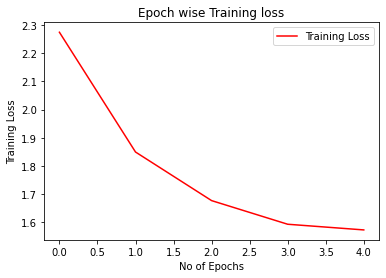

In [ ]:
plt.plot(epoch,epoch_loss,label = "Training Loss", color = "red")
plt.xlabel("No of Epochs")
plt.ylabel("Training Loss")
plt.title("Epoch wise Training loss")
plt.legend()
plt.show()

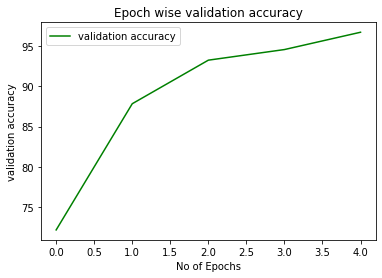

In [ ]:
plt.plot(epoch,epoch_val_acc,label = "validation accuracy" , color = "green")
plt.xlabel("No of Epochs")
plt.ylabel("validation accuracy")
plt.title("Epoch wise validation accuracy")
plt.legend()
plt.show()

In [ ]:
class TestingDataset(Dataset):
  def __init__(self,metadata,transform):
    self.metadata = pd.read_csv(metadata)
    self.len = self.metadata.shape[0]
    self.transform = transform
  
  def __len__(self):
    return self.len
  
  def __getitem__(self,index):
    image = os.path.join("Dataset",self.metadata.iloc[index]["Image_Path"])
    image = Image.open(image).convert("RGB")
    image = self.transform(image)
    return image

transform_list = transforms.Compose([
              transforms.ToTensor(),# convert the data into tensor
              transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # normalize the image
              transforms.Resize((128,128)) # resize the image
  ])
image_dataset = TestingDataset(metadata = "CSV_Datset/test_set.csv",transform = transform_list)
test_dataloader = DataLoader(dataset = image_dataset,batch_size = 32,shuffle = False)


In [ ]:
predict = []
with torch.no_grad():
  count = 0
  for batch_idx ,(image) in tqdm(enumerate(test_dataloader)):
    image = image.to(device)
    pred_prob = model(image) # predict probability
    predicted_label = torch.argmax(pred_prob,dim = 1).tolist() # select highest probability
    predict.extend(predicted_label)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
15it [00:22,  1.52s/it]


In [ ]:
### Load to CSV file
test_data = pd.read_csv("CSV_Datset/test_set.csv")
test_data["Class"] = predict
test_data.to_csv("Test_data.csv")

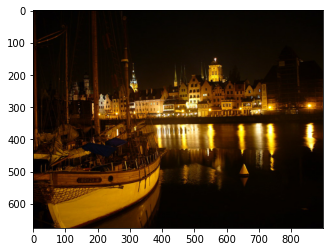

'Boat'

In [ ]:
## Showing the result for testing data
list_class_dir = os.listdir(f"Dataset/Training")
dataset = []
class_dict = {index :folder for index,folder in enumerate(list_class_dir)}
index = 10
image_path = os.path.join("Dataset",test_data.iloc[index]["Image_Path"])
image = np.array(Image.open(image_path))
plt.imshow(image)
plt.show()
class_dict[int(test_data.iloc[index]["Class"])]